### Importing libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import keras
import matplotlib.pyplot as plt # for plotting
import os # provides a way of using operating system dependent functionality
import cv2 #Image handling library
import numpy as np

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
# Import of keras model and hidden layers for our convolutional network
from keras.layers import Conv2D, Activation, MaxPool2D, Dense, Flatten, Dropout

### No of categories

In [3]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('Hand gestures/Train/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'01_palm': 0,
 '02_l': 1,
 '03_fist': 2,
 '04_fist_moved': 3,
 '05_thumb': 4,
 '06_index': 5,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 8,
 '10_down': 9}

In [4]:
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
IMG_SIZE = 224

# paths for dataset
data_path = "Hand gestures/"

In [5]:
# Loading the images and their class(0 - 9)
image_data = []
for dr in os.listdir(data_path):
    for category in CATEGORIES:
        class_index = CATEGORIES.index(category)
        path = os.path.join(data_path, dr, category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                image_data.append([cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)), class_index])
            except Exception as e:
                pass
image_data[0]

[array([[ 6,  6,  6, ...,  5,  6,  5],
        [ 6,  6,  6, ...,  4,  6,  6],
        [ 6,  5,  6, ...,  4,  5,  3],
        ...,
        [ 5,  6,  5, ...,  6,  6,  6],
        [ 5,  5,  4, ...,  6,  6,  4],
        [ 6,  6,  5, ...,  7,  5, 12]], dtype=uint8), 0]

In [6]:
# shuffle the input data
import random
random.shuffle(image_data)

input_data = []
label = []
for X, y in image_data:
    input_data.append(X)
    label.append(y)
    
label[0:20]

[8, 7, 2, 0, 1, 3, 9, 3, 6, 3, 6, 0, 9, 2, 1, 1, 2, 0, 8, 9]

### sample images

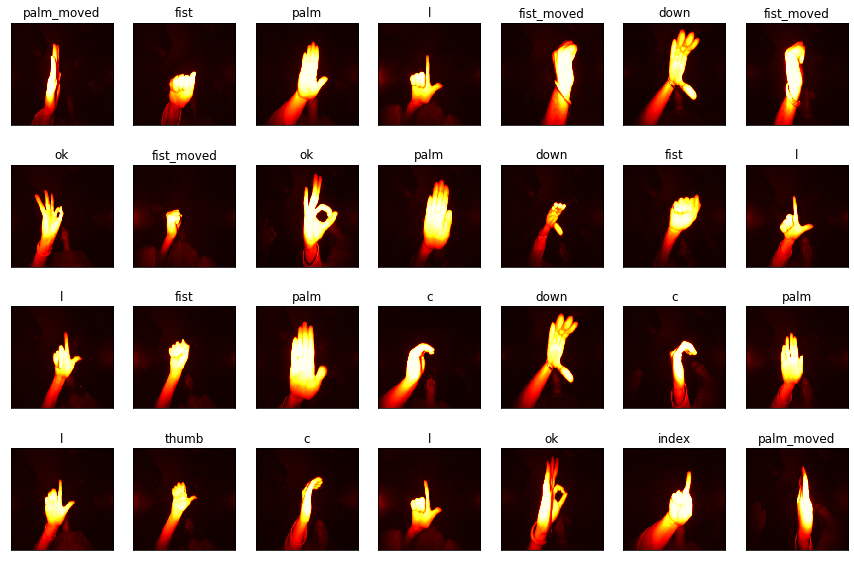

In [7]:
plt.figure(1, figsize=(15,10))
my_set=set()
for i in range(1,29):
    plt.subplot(4,7,i)
    plt.imshow(image_data[i][0], cmap='hot')
    plt.xticks([])
    plt.yticks([])
    plt.title(CATEGORIES[label[i]][3:])
plt.show()

In [8]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [9]:
train_path = 'Hand gestures/Train'
valid_path = 'Hand gestures/Test'

### Using Transfer learning for predicting hand gestures

##### Using VGG16 model

In [10]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [11]:
for layer in vgg.layers:
  layer.trainable = False

In [12]:
folders = glob('Hand gestures/Train/*')

In [13]:
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [14]:
model = Model(inputs=vgg.input, outputs=prediction)

In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [16]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [17]:
from keras.preprocessing.image import ImageDataGenerator

In [18]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [19]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [20]:
training_set = train_datagen.flow_from_directory('Hand gestures/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 18045 images belonging to 10 classes.


In [21]:
test_set = test_datagen.flow_from_directory('Hand gestures/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1955 images belonging to 10 classes.


In [22]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)


Epoch 1/5
564/564 [==============================] - 647s 1s/step - loss: 0.1161 - accuracy: 0.9756 - val_loss: 0.0127 - val_accuracy: 0.9847
Epoch 2/5
564/564 [==============================] - 651s 1s/step - loss: 0.0053 - accuracy: 0.9997 - val_loss: 0.0015 - val_accuracy: 0.9913
Epoch 3/5
564/564 [==============================] - 613s 1s/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 0.0232 - val_accuracy: 0.9959
Epoch 4/5
564/564 [==============================] - 1725s 3s/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 1.8999e-04 - val_accuracy: 0.9944
Epoch 5/5
564/564 [==============================] - 333s 590ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 4.7454e-04 - val_accuracy: 1.0000


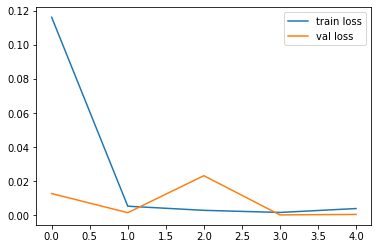

<Figure size 432x288 with 0 Axes>

In [23]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

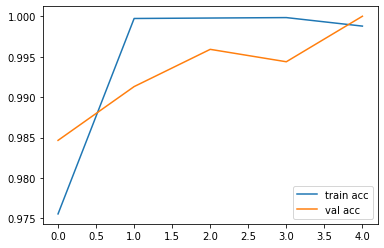

<Figure size 432x288 with 0 Axes>

In [24]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [25]:
import tensorflow as tf

from keras.models import load_model

model.save('handgestures.h5')